In [68]:
import sys; sys.path.append("../")
from network_model import get_communities, get_community_membership, get_node_community_map

from tqdm import tqdm
import networkx as nx
import numpy as np
import pickle

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({"font.size" : 15,
                     "figure.dpi" : 100, 
                     "grid.alpha" : 0.3, 
                     "axes.grid": True, 
                     "axes.axisbelow" : True,
                     "figure.figsize":(8,6),
                     "mathtext.fontset":"cm",
                     "xtick.labelsize": 14,
                     "ytick.labelsize": 14,
                     "axes.labelsize": 16, 
                     "legend.fontsize": 13.5})
USE_TEX = False
if USE_TEX:
    plt.rc("text", usetex=True)
    plt.rc("text.latex", preamble=r"""
     \usepackage{times}
     \usepackage{mathptmx}""")
else:
    plt.rc("text", usetex=False)
plt.rc("font", family="serif")

In [234]:
def sda_prob(d, a=8, b=3):
    return 1 / (1 + ((1/b)*d)**a)

In [235]:
def build_graph(P):
    G = nx.Graph()
    for i in range(1250):
        G.add_node(i)
        
    coin_flips = np.random.uniform(size=780625)
    k = 0
    for i in range(len(P)):
        for j in range(i+1, len(P)):
            if P[i][j] > coin_flips[k]:
                G.add_edge(i,j)
            k += 1
            
    return G

In [242]:
W = np.random.normal(1, 0.02, size=1250)
pairwise_distances = []
for i in range(len(W)):
    for j in range(i+1, len(W)):
        pairwise_distances.append(np.abs(W[i]-W[j]))


mean_dist = np.mean(pairwise_distances)

for b in tqdm(np.linspace(mean_dist/15, mean_dist/10, 5)):
    for a in [16, 20]:
        prob_attach = np.zeros((1250,1250))
        k=0
        for i in range(len(W)):
            for j in range(i+1,len(W)):
                p = sda_prob(pairwise_distances[k], a=a, b=b)
                prob_attach[i][j] = p
                prob_attach[j][i] = p
                k+=1
        G = build_graph(prob_attach)
        communities = get_communities(G)
        print(f"a = {a}, b = {b:.3f} : {len(communities)}")
        break
    break


# ensure that graph is connected
connected_components = list(nx.connected_components(G))
largest_component = list(connected_components[0])

largest_component_wealths = W[np.array(largest_component)]

for i in range(1, len(connected_components)):
    comp = list(connected_components[i])
    node = np.random.choice(comp)
    closest_largest_component_node = (np.abs(largest_component_wealths - W[node])).argmin()
    G.add_edge(node, largest_component[closest_largest_component_node])
    
communities = get_communities(G)
community_membership = get_community_membership(G, communities)

  0%|          | 0/5 [00:01<?, ?it/s]

a = 16, b = 0.001 : 33


In [169]:
W = np.random.normal(1, 0.02, size=1250)
pairwise_distances = []
for i in range(len(W)):
    for j in range(i+1, len(W)):
        pairwise_distances.append(np.abs(W[i]-W[j]))

In [204]:
mean_dist = np.mean(pairwise_distances)

for b in tqdm(np.linspace(mean_dist/15, mean_dist/10, 5)):
    for a in [16, 20]:
        prob_attach = np.zeros((1250,1250))
        for i in range(len(W)):
            for j in range(i+1,len(W)):
                p = sda_prob(W[i], W[j], a=a, b=b)
                prob_attach[i][j] = p
                prob_attach[j][i] = p
        G = build_graph(prob_attach)
        communities = get_communities(G)
        print(f"a = {a}, b = {b:.3f} : {len(communities)}")
        break
    break

  0%|          | 0/5 [00:03<?, ?it/s]

a = 16, b = 0.001 : 33


In [196]:
# ensure that graph is connected
connected_components = list(nx.connected_components(G))
largest_component = list(connected_components[0])

largest_component_wealths = W[np.array(largest_component)]

for i in range(1, len(connected_components)):
    comp = list(connected_components[i])
    node = np.random.choice(comp)
    
    closest_largest_component_node = (np.abs(largest_component_wealths - W[node])).argmin()
    G.add_edge(node, largest_component[closest_largest_component_node])
    
assert nx.is_connected(G)

In [243]:
# construct communities and augmented communities
communities = get_communities(G)
community_membership = get_community_membership(G, communities)

augmented_communities = {}
for agent in community_membership:
    comms = community_membership[agent]
    for c in comms:
        if c not in augmented_communities:
            augmented_communities[c] = {agent}
        else:
            augmented_communities[c].add(agent) 
augmented_communities = {k:np.array(list(v)) for k,v in augmented_communities.items()}
del augmented_communities[max(augmented_communities.keys())]


# get community adjacency matrix and degree distribution
adjacency = dict((n, set(nbrdict.keys())) for n, nbrdict in G.adjacency())
node_community_map = get_node_community_map(communities)

community_adjacency = {}
for i,c in enumerate(communities):
    community_adjacency[i] = set()
    for node in c:
        node_neighbours = adjacency[node]
        for neighbour in node_neighbours:
            neighbouring_community = node_community_map[neighbour]
            if neighbouring_community != i:
                community_adjacency[i].add(neighbouring_community)
comm_degrees = [len(x) for x in list(community_adjacency.values())]

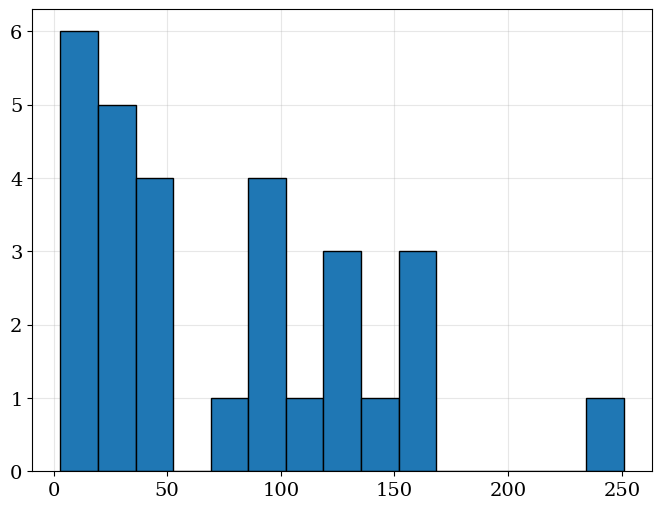

In [244]:
community_sizes = [len(x) for x in list(augmented_communities.values()) if len(x)!=1250]
plt.hist(community_sizes, bins=15, edgecolor="k")
plt.show()

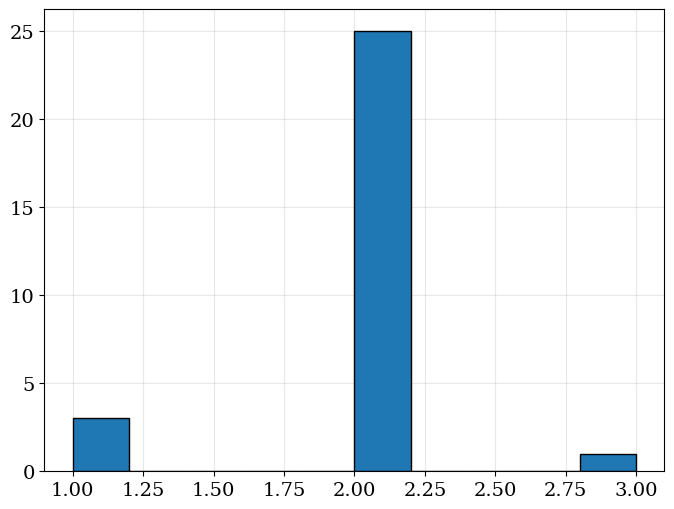

In [245]:
plt.hist(comm_degrees, edgecolor="k")
plt.show()

In [246]:
# with open("../augmented_communities.pickle", "rb") as f:
#     augmented_communities = pickle.load(f)

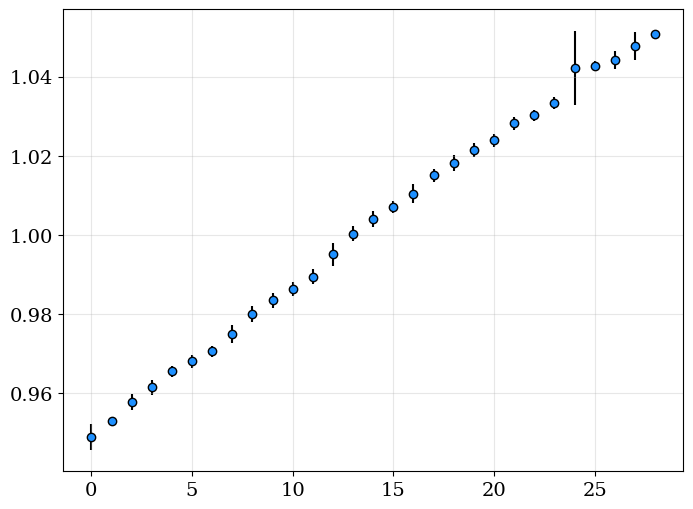

In [247]:
mean_community_wealths = []
std_community_wealths = []
for c in augmented_communities:
    mean_community_wealths.append(np.mean(W[augmented_communities[c]]))
    std_community_wealths.append(np.std(W[augmented_communities[c]]))
sorted_idx = np.argsort(mean_community_wealths)

plt.errorbar(np.arange(len(mean_community_wealths)), 
             np.array(mean_community_wealths)[sorted_idx],
             np.array(std_community_wealths)[sorted_idx],
             fmt="None",
             color="k",
             zorder=0)

    
plt.scatter(np.arange(len(mean_community_wealths)), 
            np.array(mean_community_wealths)[sorted_idx], 
            color="dodgerblue", 
            edgecolor="k")


plt.show()

In [256]:
sys.getsizeof(W) + sys.getsizeof(communities) + sys.getsizeof(community_membership) + sys.getsizeof(G)

47408

In [257]:
47408 * 2048

97091584